In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2023-05-07 10:33:20 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...


In [ ]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, broadwell)
  Threads: 2 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2




<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />

In [ ]:
using Pkg

In [ ]:
Pkg.add(url="https://github.com/JuliaQuantumControl/GRAPELinesearchAnalysis.jl.git")

In [ ]:
Pkg.add("QuantumControl")

In [ ]:
using GRAPELinesearchAnalysis

In [ ]:
using QuantumControl

In [ ]:
Pkg.add("QuantumControlBase")

In [ ]:
using QuantumControlBase

In [ ]:
ϵ1(t) = 0.2 * QuantumControl.Shapes.flattop(t, T=300, t_rise=0.3, func=:blackman);
ϵ2(t) = 0.2 * QuantumControl.Shapes.flattop(t, T=300, t_rise=0.3, func=:blackman);
ϵ3(t) = 0.2 * QuantumControl.Shapes.flattop(t, T=300, t_rise=0.3, func=:blackman);
ϵ4(t) = 0.2 * QuantumControl.Shapes.flattop(t, T=300, t_rise=0.3, func=:blackman);

In [ ]:
"""Two-level-system Hamiltonian."""
function hamiltonian(Ω1=1.0, ϵ1=ϵ1,ϵ2=ϵ2,ϵ3=ϵ3,ϵ4=ϵ4, Ω2=1.0, J=0.01)
    Iσ̂_z = ComplexF64[
        1  0  0  0
        0 -1  0  0
        0  0  1  0
        0  0  0  -1
    ]
    Iσ̂_x = ComplexF64[
        0  1  0  0
        1  0  0  0
        0  0  0  1
        0  0  1  0
    ]
    σ̂_xI = ComplexF64[
        0  0  1  0
        0  0  0  1
        1  0  0  0
        0  1  0  0
    ]
    Iσ̂_y = ComplexF64[
        0  -1im  0  0
        1im  0  0  0
        0  0  0  -1im
        0  0  1im  0
    ]
    σ̂_yI = ComplexF64[
        0  0  -1im  0
        0  0  0  -1im
        1im  0  0  0
        0  1im  0  0
    ]
    σ̂_zI = ComplexF64[
        1  0  0  0
        0  1  0  0
        0  0 -1  0
        0  0  0  -1
    ]
    σ̂_x_x = ComplexF64[
        0  0  0  1
        0  0  1  0
        0  1  0  0
        1  0  0  0
    ]
    σ̂_y_y = ComplexF64[
        0  0  0 -1
        0  0  1  0
        0  1  0  0
       -1  0  0  0
    ]
    σ̂_z_z = ComplexF64[
        1  0  0  0
        0 -1  0  0
        0  0 -1  0
        0  0  0  1
    ]
    Ĥ₀ = -0.5 * (Ω1 * Iσ̂_z + Ω2 * σ̂_zI) + J * (σ̂_z_z)
    Ĥ₁ = Iσ̂_x
    Ĥ2 = σ̂_xI
    Ĥ3 = Iσ̂_y
    Ĥ4 = σ̂_yI
    return (Ĥ₀, (Ĥ₁, ϵ1), (Ĥ2, ϵ2), (Ĥ3, ϵ3), (Ĥ4, ϵ4))
end;

In [ ]:
H = hamiltonian();

In [ ]:
T = 300
N = 3000
dt = T/N
omega1=1
omega2=1
J=0.01

ampl0=0.2

psi_11= [0, 0, 0, 1]
    Iσ̂_z = ComplexF64[
        1  0  0  0
        0 -1  0  0
        0  0  1  0
        0  0  0  -1
    ]
    Iσ̂_x = ComplexF64[
        0  1  0  0
        1  0  0  0
        0  0  0  1
        0  0  1  0
    ]
    σ̂_xI = ComplexF64[
        0  0  1  0
        0  0  0  1
        1  0  0  0
        0  1  0  0
    ]
    Iσ̂_y = ComplexF64[
        0  -1im  0  0
        1im  0  0  0
        0  0  0  -1im
        0  0  1im  0
    ]
    σ̂_yI = ComplexF64[
        0  0  -1im  0
        0  0  0  -1im
        1im  0  0  0
        0  1im  0  0
    ]
    σ̂_zI = ComplexF64[
        1  0  0  0
        0  1  0  0
        0  0 -1  0
        0  0  0  -1
    ]
    σ̂_x_x = ComplexF64[
        0  0  0  1
        0  0  1  0
        0  1  0  0
        1  0  0  0
    ]
    σ̂_y_y = ComplexF64[
        0  0  0 -1
        0  0  1  0
        0  1  0  0
       -1  0  0  0
    ]
    σ̂_z_z = ComplexF64[
        1  0  0  0
        0 -1  0  0
        0  0 -1  0
        0  0  0  1
    ]

4×4 Matrix{ComplexF64}:
 1.0+0.0im   0.0+0.0im   0.0+0.0im  0.0+0.0im
 0.0+0.0im  -1.0+0.0im   0.0+0.0im  0.0+0.0im
 0.0+0.0im   0.0+0.0im  -1.0+0.0im  0.0+0.0im
 0.0+0.0im   0.0+0.0im   0.0+0.0im  1.0+0.0im

In [ ]:
tlist = collect(range(0, 300, length=3000));

In [ ]:
Pkg.add("Plots")
using Plots
Plots.default(
    linewidth               = 3,
    size                    = (550, 300),
    legend                  = :right,
    foreground_color_legend = nothing,
    background_color_legend = RGBA(1, 1, 1, 0.8)
)

In [ ]:
function plot_control(pulse::Vector, tlist)
    plot(tlist, pulse, xlabel="time", ylabel="amplitude", legend=false)
end

plot_control(ϵ::T, tlist) where {T<:Function} = plot_control([ϵ(t) for t in tlist], tlist);

In [ ]:
function ket(label)
    result = Dict("00" => Vector{ComplexF64}([1, 0, 0, 0]), "01" => Vector{ComplexF64}([0, 1, 0, 0]), "10" => Vector{ComplexF64}([0, 0, 1, 0]), "11" => Vector{ComplexF64}([0, 0, 0, 1]))
    return result[string(label)]
end;

In [ ]:
basis = [ket("00"),ket("01"),ket("10"),ket("11")];

In [ ]:
CNOT = [
    1  0  0  0
    0  1  0  0
    0  0  0  1
    0  0  1  0
];

In [ ]:
basis_tgt = transpose(CNOT) * basis;

In [ ]:
objectives = [Objective(initial_state = psi, target_state = psitgt, generator = H) for
    (psi, psitgt) ∈ zip(basis, basis_tgt)];

objectives


4-element Vector{Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}, Tuple{Matrix{ComplexF64}, typeof(ϵ3)}, Tuple{Matrix{ComplexF64}, typeof(ϵ4)}}}}:
 Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}, Tuple{Matrix{ComplexF64}, typeof(ϵ3)}, Tuple{Matrix{ComplexF64}, typeof(ϵ4)}}}(…)
 Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}, Tuple{Matrix{ComplexF64}, typeof(ϵ3)}, Tuple{Matrix{ComplexF64}, typeof(ϵ4)}}}(…)
 Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}, Tuple{Matrix{ComplexF64}, typeof(ϵ3)}, Tuple{Matrix{ComplexF64}, typeof(ϵ4)}}}(…)
 Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF

In [ ]:
using LinearAlgebra

In [ ]:
U_guess = [basis[i] ⋅ guess_states[j] for i = 1:4, j = 1:4];

In [ ]:
problem = ControlProblem(
    objectives=objectives,
    tlist=tlist,
    pulse_options=Dict(),
    iter_stop=500,
    J_T=QuantumControl.Functionals.J_T_sm,
    check_convergence=res -> begin
        ((res.J_T < 1e-3) && (res.converged = true) && (res.message = "J_T < 10⁻³"))
    end,
);

In [ ]:
function plot_population(pop00::Vector, pop01::Vector, pop10::Vector,pop11::Vector,tlist)
    fig = plot(tlist, pop00, label="00", xlabel="time", ylabel="population")
    plot!(fig, tlist, pop01; label="01")
    plot!(fig, tlist, pop10; label="10")
    plot!(fig, tlist, pop11; label="11")
end;

In [ ]:
Pkg.add("QuantumPropagators")
using QuantumPropagators

In [ ]:
function store_pulses(wrk, iteration, _...)
    L = length(wrk.controls)
    ϵ_opt = reshape(wrk.pulsevals, L, :)
    opt_pulses = [QuantumControl.Controls.discretize_on_midpoints(ϵ_opt[l, :], tlist) for l=1:L]
    return Tuple(opt_pulses)
end

store_pulses (generic function with 1 method)

In [ ]:
Pkg.add("GRAPE")
using GRAPE

In [ ]:
wrk=GRAPE.GrapeWrk(problem; )

GrapeWrk{}(Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}, Tuple{Matrix{ComplexF64}, typeof(ϵ3)}, Tuple{Matrix{ComplexF64}, typeof(ϵ4)}}}[Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}, Tuple{Matrix{ComplexF64}, typeof(ϵ3)}, Tuple{Matrix{ComplexF64}, typeof(ϵ4)}}}(…), Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}, Tuple{Matrix{ComplexF64}, typeof(ϵ3)}, Tuple{Matrix{ComplexF64}, typeof(ϵ4)}}}(…), Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, typeof(ϵ2)}, Tuple{Matrix{ComplexF64}, typeof(ϵ3)}, Tuple{Matrix{ComplexF64}, typeof(ϵ4)}}}(…), Objective{Vector{ComplexF64}, Tuple{Matrix{ComplexF64}, Tuple{Matrix{ComplexF64}, typeof(ϵ1)}, Tuple{Matrix{ComplexF64}, type

In [ ]:
opt_result_LBFGSB = optimize(

    problem,
    method = :grape,
    force = true,
    info_hook = QuantumControlBase.chain_infohooks(

        QuantumControl.GRAPE.print_table,
        store_pulses
    )
);

 iter.        J_T     |∇J_T|       ΔJ_T   FG(F)    secs
     0   8.90e-01   9.90e-01        n/a    1(0)     3.6
     1   8.78e-01   1.25e+00  -1.27e-02    1(0)     0.8
     2   8.02e-01   9.78e-01  -7.60e-02    1(0)     0.7
     3   7.35e-01   1.36e+00  -6.65e-02    2(0)     1.4
     4   5.81e-01   2.83e+00  -1.54e-01    3(0)     2.0
     5   5.52e-01   2.56e+00  -2.98e-02    3(0)     2.0
     6   4.49e-01   2.57e+00  -1.03e-01    1(0)     0.7
     7   1.69e-01   2.47e+00  -2.79e-01    2(0)     1.7
     8   5.42e-02   1.21e+00  -1.15e-01    1(0)     1.2
     9   2.74e-02   8.17e-01  -2.68e-02    1(0)     0.7
    10   1.11e-02   3.73e-01  -1.63e-02    1(0)     0.7
    11   5.12e-03   1.98e-01  -6.02e-03    1(0)     0.7
    12   2.63e-03   1.19e-01  -2.49e-03    1(0)     0.7
    13   1.71e-03   1.18e-01  -9.23e-04    1(0)     0.7
    14   1.03e-03   7.74e-02  -6.76e-04    1(0)     0.7
    15   5.13e-04   5.55e-02  -5.17e-04    1(0)     0.7


In [ ]:
opt_result_LBFGSB

GRAPE Optimization Result
-------------------------
- Started at 2023-05-07T10:58:25.597
- Number of objectives: 4
- Number of iterations: 15
- Number of pure func evals: 0
- Number of func/grad evals: 22
- Value of functional: 5.13042e-04
- Reason for termination: J_T < 10⁻³
- Ended at 2023-05-07T10:58:44.321 (18 seconds, 724 milliseconds)


In [ ]:
function plot_pulse1(pulse::Vector, tlist)
    plot(tlist, pulse, xlabel="time", ylabel="amplitude" , legend=false)

    ylabel!("pulse amplitude")
end

plot_control(ϵ::T, tlist) where {T<:Function} = plot_control([ϵ(t) for t in tlist], tlist);

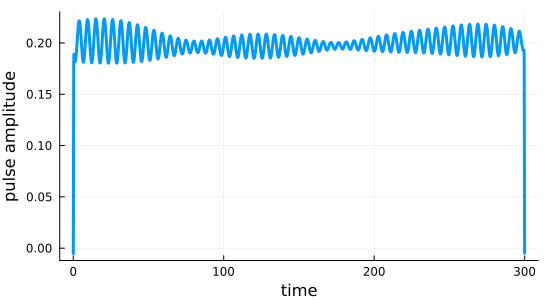

In [ ]:
fig2 = plot_pulse1(opt_result_LBFGSB.optimized_controls[1], tlist)

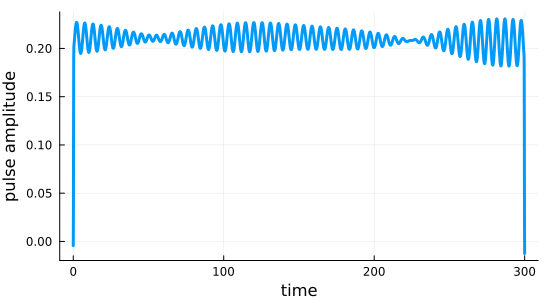

In [ ]:
fig2 = plot_pulse1(opt_result_LBFGSB.optimized_controls[2], tlist)

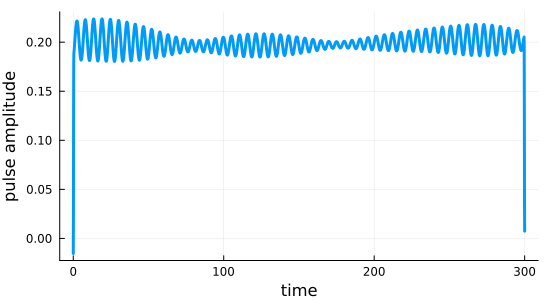

In [ ]:
fig3 = plot_pulse1(opt_result_LBFGSB.optimized_controls[3], tlist)

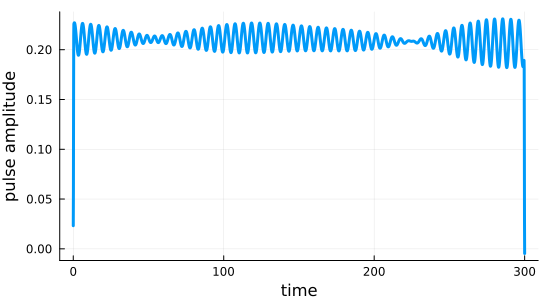

In [ ]:
fig4 = plot_pulse1(opt_result_LBFGSB.optimized_controls[4], tlist)

In [ ]:
all_pulses=opt_result_LBFGSB.records

In [ ]:
ket_11= Vector{ComplexF64}([0, 0, 0, 1])
ket_00= Vector{ComplexF64}([1, 0, 0, 0])
ket_01= Vector{ComplexF64}([0, 1, 0, 0])
ket_10= Vector{ComplexF64}([0, 0, 1, 0])
bra_00=reshape(ket_00, (4, 1))
bra_01=reshape(ket_01, (4, 1))
bra_10=reshape(ket_10, (4, 1))
bra_11=reshape(ket_11, (4, 1))

4×1 Matrix{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 1.0 + 0.0im

In [ ]:
obs00 = Float64[]
obs01 = Float64[]
obs10 = Float64[]
obs11 = Float64[]
psi_tj=ket_00
for i in 1:3000
    opt1 = opt_result_LBFGSB.optimized_controls[1][i]
    opt2 = opt_result_LBFGSB.optimized_controls[2][i]
    opt3 = opt_result_LBFGSB.optimized_controls[3][i]
    opt4 = opt_result_LBFGSB.optimized_controls[4][i]
    H_t = (-0.5) *( omega1 * Iσ̂_z +  omega2 * σ̂_zI )+ J* ( σ̂_z_z) + opt1 * Iσ̂_x + opt2 * σ̂_xI +  opt3 * Iσ̂_y + opt4 * σ̂_yI
    U = exp(-1im * H_t * dt)
    psi_tj= U * psi_tj

    psi_t00= dot(bra_00 ,psi_tj)
    psi_t01= dot(bra_01 ,psi_tj)
    psi_t10= dot(bra_10 ,psi_tj)
    psi_t11= dot(bra_11 ,psi_tj)
    psi2_t00j= abs.(psi_t00[1]).^2
    psi2_t01j= abs.(psi_t01[1]).^2
    psi2_t10j= abs.(psi_t10[1]).^2
    psi2_t11j= abs.(psi_t11[1]).^2

    append!(obs00,psi2_t00j)
    append!(obs01,psi2_t01j)
    append!(obs10,psi2_t10j)
    append!(obs11,psi2_t11j)
end

println(obs00)
println(obs01)
println(obs10)
println(obs11)

[0.9999917905277456, 0.9999213302855066, 0.9989292060156179, 0.9950363146153023, 0.9878345765031679, 0.9775542799083984, 0.9643468263083921, 0.9484116071395275, 0.9299913093277561, 0.9093662113607939, 0.8868476722602557, 0.8627710445742777, 0.8374882614151197, 0.811360355568909, 0.7847501652303854, 0.7580154659148761, 0.7315027420900314, 0.705541776149578, 0.6804411881832305, 0.6564850097542488, 0.6339303211705051, 0.6130059274063299, 0.5939119959074902, 0.5768205329397356, 0.5618765366212018, 0.5491996365724666, 0.5388860138867294, 0.5310103918027979, 0.5256278971921535, 0.5227756150699602, 0.5224736913591762, 0.5247258809578893, 0.5295194861416784, 0.5368246814943186, 0.5465932727796211, 0.5587569853821351, 0.5732254203371999, 0.5898838501273204, 0.6085910504541254, 0.6291773768236995, 0.651443295377484, 0.6751585659821582, 0.7000622528002617, 0.7258637045987063, 0.7522446055927702, 0.7788621497279178, 0.8053533393040083, 0.8313403552404643, 0.8564368936076528, 0.8802553137839996, 0.

In [ ]:
function plot_population1(pop00::Vector, pop01::Vector, pop10::Vector,pop11::Vector,tlist)
    fig = plot(tlist, pop00, label="00", xlabel="time", ylabel="population")
    plot!(fig, tlist, pop01; label="01")
    plot!(fig, tlist, pop10; label="10")
    plot!(fig, tlist, pop11; label="11")
end;

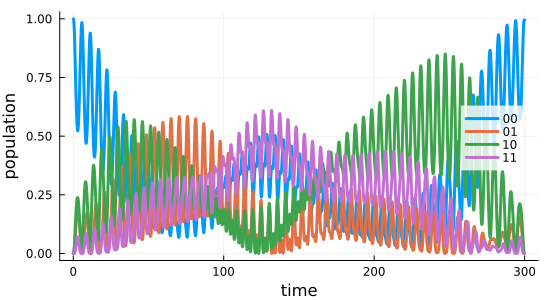

In [ ]:
plot_population1(obs00, obs01, obs10, obs11, tlist)

In [ ]:

obs200 = Float64[]
obs201 = Float64[]
obs210 = Float64[]
obs211 = Float64[]
psi_tj=ket_01
for i in 1:3000
    opt1 = opt_result_LBFGSB.optimized_controls[1][i]
    opt2 = opt_result_LBFGSB.optimized_controls[2][i]
    opt3 = opt_result_LBFGSB.optimized_controls[3][i]
    opt4 = opt_result_LBFGSB.optimized_controls[4][i]
    H_t = (-0.5) *( omega1 * Iσ̂_z +  omega2 * σ̂_zI )+ J* ( σ̂_z_z) + opt1 * Iσ̂_x + opt2 * σ̂_xI +  opt3 * Iσ̂_y + opt4 * σ̂_yI
    U = exp(-1im * H_t * dt)
    psi_tj= U * psi_tj

    psi_t00= dot(bra_00 ,psi_tj)
    psi_t01= dot(bra_01 ,psi_tj)
    psi_t10= dot(bra_10 ,psi_tj)
    psi_t11= dot(bra_11 ,psi_tj)
    psi2_t00j= abs.(psi_t00[1]).^2
    psi2_t01j= abs.(psi_t01[1]).^2
    psi2_t10j= abs.(psi_t10[1]).^2
    psi2_t11j= abs.(psi_t11[1]).^2

    append!(obs200,psi2_t00j)
    append!(obs201,psi2_t01j)
    append!(obs210,psi2_t10j)
    append!(obs211,psi2_t11j)
end

println(obs200)
println(obs201)
println(obs210)
println(obs211)

[2.6186756283270734e-6, 4.7445897107465964e-6, 0.00031224838542329684, 0.0018140089264539964, 0.004726270334535256, 0.00892595171571844, 0.014313364826544288, 0.020765562372357663, 0.02814037619772721, 0.036281088636792726, 0.04502153991838284, 0.05419145327755153, 0.06362174805613337, 0.07314961039850754, 0.08262310152001558, 0.09190510478455452, 0.10087644426684114, 0.1094380478292066, 0.11751207521390618, 0.12504198396519314, 0.13199156049625133, 0.13834299740249115, 0.14409414820857758, 0.14925513423601758, 0.1538445125974185, 0.15788523734443677, 0.1614006560346692, 0.1644107807059519, 0.16692905553969448, 0.16895981426583717, 0.1704965802856599, 0.17152131389431738, 0.1720046566972582, 0.17190716646227475, 0.17118147945798826, 0.16977528491941143, 0.16763495047779559, 0.16470960057211473, 0.16095542383452602, 0.15633997138465777, 0.1508462063821192, 0.14447607591982897, 0.13725339862575023, 0.12922589386822045, 0.12046621946967875, 0.11107193221678235, 0.10116433686604086, 0.0908

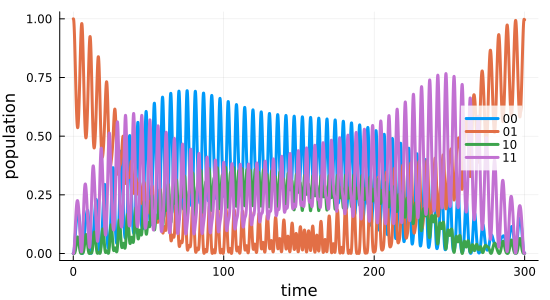

In [ ]:
plot_population1(obs200, obs201, obs210, obs211, tlist)

In [ ]:

obs300 = Float64[]
obs301 = Float64[]
obs310 = Float64[]
obs311 = Float64[]
psi_tj=ket_10
for i in 1:3000
    opt1 = opt_result_LBFGSB.optimized_controls[1][i]
    opt2 = opt_result_LBFGSB.optimized_controls[2][i]
    opt3 = opt_result_LBFGSB.optimized_controls[3][i]
    opt4 = opt_result_LBFGSB.optimized_controls[4][i]
    H_t = (-0.5) *( omega1 * Iσ̂_z +  omega2 * σ̂_zI )+ J* ( σ̂_z_z) + opt1 * Iσ̂_x + opt2 * σ̂_xI +  opt3 * Iσ̂_y + opt4 * σ̂_yI

    U = exp(-1im * H_t * dt)
    psi_tj= U * psi_tj

    psi_t00= dot(bra_00 ,psi_tj)
    psi_t01= dot(bra_01 ,psi_tj)
    psi_t10= dot(bra_10 ,psi_tj)
    psi_t11= dot(bra_11 ,psi_tj)
    psi2_t00j= abs.(psi_t00[1]).^2
    psi2_t01j= abs.(psi_t01[1]).^2
    psi2_t10j= abs.(psi_t10[1]).^2
    psi2_t11j= abs.(psi_t11[1]).^2

    append!(obs300,psi2_t00j)
    append!(obs301,psi2_t01j)
    append!(obs310,psi2_t10j)
    append!(obs311,psi2_t11j)
end

println(obs300)
println(obs301)
println(obs310)
println(obs311)

[5.590781986257314e-6, 7.392477480404259e-5, 0.0007583085399777708, 0.003143945579422594, 0.007403748111179437, 0.01339755996323963, 0.021028210009063217, 0.03016399339123144, 0.04064268093442225, 0.05227644492385479, 0.06485749857663428, 0.07816421659298808, 0.09196748471170635, 0.10603701836675848, 0.12014739499341254, 0.13408356132524202, 0.14764560559689888, 0.1606526237212324, 0.17294555642518936, 0.184388928632686, 0.19487148024788034, 0.20430573578475184, 0.21262661574483369, 0.21978924207232137, 0.22576613050415367, 0.23054399175440912, 0.2341203794577347, 0.23650042466627516, 0.2376938843371351, 0.23771270543297673, 0.23656926858793062, 0.23427542808498067, 0.23084241102767258, 0.22628158130760426, 0.2206060166546875, 0.21383279302512614, 0.205985822879175, 0.19709905513545317, 0.18721981680018207, 0.1764120608414048, 0.1647592824944203, 0.15236687682987746, 0.13936373341005245, 0.12590289792183307, 0.11216117401487381, 0.09833758899029187, 0.08465070198591228, 0.0713347902223

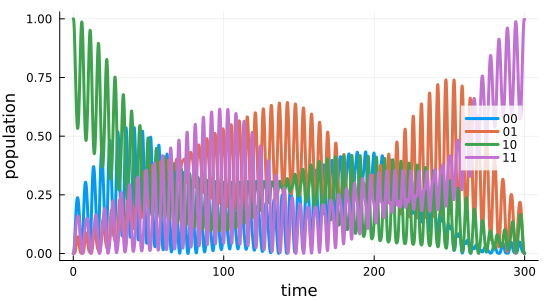

In [ ]:
plot_population1(obs300, obs301, obs310, obs311, tlist)

In [ ]:

obs400 = Float64[]
obs401 = Float64[]
obs410 = Float64[]
obs411 = Float64[]
psi_tj=ket_11
for i in 1:3000
    opt1 = opt_result_LBFGSB.optimized_controls[1][i]
    opt2 = opt_result_LBFGSB.optimized_controls[2][i]
    opt3 = opt_result_LBFGSB.optimized_controls[3][i]
    opt4 = opt_result_LBFGSB.optimized_controls[4][i]
    H_t = (-0.5) *( omega1 * Iσ̂_z +  omega2 * σ̂_zI )+ J* ( σ̂_z_z) + opt1 * Iσ̂_x + opt2 * σ̂_xI +  opt3 * Iσ̂_y + opt4 * σ̂_yI
    U = exp(-1im * H_t * dt)
    psi_tj= U * psi_tj

    psi_t00= dot(bra_00 ,psi_tj)
    psi_t01= dot(bra_01 ,psi_tj)
    psi_t10= dot(bra_10 ,psi_tj)
    psi_t11= dot(bra_11 ,psi_tj)
    psi2_t00j= abs.(psi_t00[1]).^2
    psi2_t01j= abs.(psi_t01[1]).^2
    psi2_t10j= abs.(psi_t10[1]).^2
    psi2_t11j= abs.(psi_t11[1]).^2

    append!(obs400,psi2_t00j)
    append!(obs401,psi2_t01j)
    append!(obs410,psi2_t10j)
    append!(obs411,psi2_t11j)
end

println(obs400)
println(obs401)
println(obs410)
println(obs411)

[1.463959505913128e-11, 3.499777250750029e-10, 2.370589805567257e-7, 5.730878820790612e-6, 3.540505111689693e-5, 0.00012220841264260846, 0.0003115988559987308, 0.000658837096881539, 0.0012256335400922936, 0.0020762550785561546, 0.0032732892447248675, 0.004873285555180631, 0.006922505817039053, 0.009453015665823754, 0.012479338256185368, 0.015995867975326046, 0.01997520804622732, 0.024367552299981776, 0.029101180177672447, 0.03408407764787035, 0.03920663808536145, 0.044345339406425606, 0.04936724013909704, 0.05413509075192414, 0.05851282027722453, 0.062371134328686205, 0.06559295062086559, 0.06807840282497418, 0.06974916293101595, 0.07055186523122525, 0.07046045976723252, 0.06947737706281232, 0.06763344613339076, 0.0649865707358025, 0.06161923110770316, 0.05763493667332739, 0.053153806305829554, 0.048307494165111736, 0.04323370891116653, 0.038070590950237716, 0.03295121574597595, 0.02799848126813461, 0.023320615163934785, 0.019007503611239346, 0.01512800092267624, 0.01172832906500656, 0

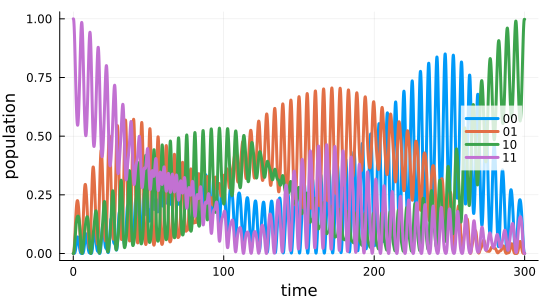

In [ ]:
plot_population1(obs400, obs401, obs410, obs411, tlist)